# Boston houses pricing dataset

### In this project, the goal is to predict the price of a house based on different features (Regression task).

## Importing Libraries

In [1]:
# Lets import relevant libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from torchsummary import summary
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Loading dataset and checking some properties

In [2]:
# Loading data into a pandas dataframe

data = pd.read_csv("/kaggle/input/bostonhoustingmlnd/housing.csv")
data2 = pd.read_csv("/kaggle/input/bostonhoustingmlnd/housing.csv")
#checking first five records from each column
data.head()

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


In [3]:
# Let's check the data types to make sure they are in float
print(data.dtypes)

RM         float64
LSTAT      float64
PTRATIO    float64
MEDV       float64
dtype: object


In [4]:
# Let's check for null values
print(data.isnull().sum())

RM         0
LSTAT      0
PTRATIO    0
MEDV       0
dtype: int64


In [5]:
# We can also look at the shape of the dataset to see how many entries we have
print(data.shape)

# Lets calculate the standard deviation of the target (will be useful later)
target_std = data['MEDV'].std()
print(target_std)

(489, 4)
165340.27765266786


## Normalizing dataset

### Now that we know the shape of our data (489, 4) and ensured that there are no NaN values, we can proceed to normalizing the dataset with StandardScalar, which will make the mean of each column 0 and the standard deviation equal 1.

In [6]:
# Normalizing dataset, where we use standardscalar to make the mean of equal 0 and standard deviation 1, this will help during training and avoid issies like exploding 
# gradients.

X = data.drop(columns=['MEDV'])  # All columns except 'diabetes'
y = data['MEDV']  # The target column


columns_to_normalize = ['RM', 'LSTAT', 'PTRATIO']  # the columns we will normalize

# Applying StandardScalar()
scaler = StandardScaler()
X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])
y = scaler.fit_transform(y.values.reshape(-1, 1)) 
# Recombining the normalized features back with the target column
y = pd.DataFrame(y, columns=['MEDV'])
data = pd.concat([X, y], axis=1)


data.head()

,RM,LSTAT,PTRATIO,MEDV
0,0.520554,-1.125077,-1.525083,0.300640
1,0.281048,-0.537070,-0.339748,-0.004498
2,1.469245,-1.259357,-0.339748,1.661047
3,1.178417,-1.413427,0.086973,1.495764
4,1.410146,-1.075605,0.086973,1.851759


### Now that we normalized our dataset we are ready to prepare for training, we will first create a pytorch dataset to which we will feed our data, we will split the data into features (RM, LSTAT and PTRATIO) and target (MEDV), and then further split to train validation and testing, then we will feed these datasets to the dataloader, which will be used for the training and testing

## Splitting dataset

In [7]:
# Now that we preprocessed data we can start by splitting the data into train, validation and test sets

# Features and target splitting
X = data.drop(columns=['MEDV']).values  # Features
y = data['MEDV'].values  # Target

# First split: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: 50% of temp goes to validation, 50% to test (so 15% each of total dataset)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Converting features and target to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


print(f"Train set size: {X_train.shape[0]} ({(X_train.shape[0] / len(X)) * 100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({(X_val.shape[0] / len(X)) * 100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({(X_test.shape[0] / len(X)) * 100:.1f}%)")


Train set size: 342 (69.9%)
Validation set size: 73 (14.9%)
Test set size: 74 (15.1%)


## Defining torch Dataset and DataLoaders

In [8]:
# Defining a simple custom Dataset class whill will be fed with out train, val and test sets
class HousingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
# Dataset objects for train, validation and test sets
train_dataset = HousingDataset(X_train_tensor, y_train_tensor)
val_dataset = HousingDataset(X_val_tensor, y_val_tensor)
test_dataset = HousingDataset(X_test_tensor, y_test_tensor)

# DataLoader objects for train, validation and test sets ( this is what we will use for the training and val loops)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle=False)

In [10]:
# We can first check one of the batches from each set to ensure proper size and everything is well

# Checking shape of a batch from the train_dataloader
for X_batch, y_batch in train_dataloader:
    print("Train batch features shape:", X_batch.shape)
    print("Train batch target shape:", y_batch.shape)
    break  # Only print the shape of the first batch

# Checking shape of a batch from the val_dataloader
for X_batch, y_batch in val_dataloader:
    print("Validation batch features shape:", X_batch.shape)
    print("Validation batch target shape:", y_batch.shape)
    break  # Only print the shape of the first batch

# Checking shape of a batch from the test_dataloader
for X_batch, y_batch in test_dataloader:
    print("Validation batch features shape:", X_batch.shape)
    print("Validation batch target shape:", y_batch.shape)
    break  # Only print the shape of the first batch

Train batch features shape: torch.Size([32, 3])
Train batch target shape: torch.Size([32])
Validation batch features shape: torch.Size([32, 3])
Validation batch target shape: torch.Size([32])
Validation batch features shape: torch.Size([32, 3])
Validation batch target shape: torch.Size([32])


In [11]:
# Checking other stuff related to null values and type of the entries in the batches, just to make sure again all is well.

for X_batch, y_batch in train_dataloader:
    print("Train batch features shape:", X_batch.shape)
    print("Train batch target shape:", y_batch.shape)
    
    # Print some random feature values (first 5 rows)
    print("First 5 feature values:", X_batch[:5])
    print("First 5 target values:", y_batch[:200])

    # Print the data type of the features
    print("Data type of features:", X_batch.dtype)
    
    # Check if there are NaN or Inf values
    if torch.isnan(X_batch).any() or torch.isinf(X_batch).any():
        print("Warning: NaN or Inf values found in features!")
    
    if torch.isnan(y_batch).any() or torch.isinf(y_batch).any():
        print("Warning: NaN or Inf values found in targets!")
    
    break  # Only print the details of the first batch


Train batch features shape: torch.Size([32, 3])
Train batch target shape: torch.Size([32])
First 5 feature values: tensor([[ 0.2515, -0.2289, -1.8096],
        [ 1.2033,  0.2615, -2.6156],
        [ 0.8052, -1.3300, -0.4346],
        [ 1.8223, -1.0869, -0.5294],
        [-0.5759,  0.2022,  0.2766]])
First 5 target values: tensor([ 0,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
         0,  0,  1, -1, -1,  0,  0,  0,  0,  0,  0, -1,  2,  0])
Data type of features: torch.float32


## Defining classifier (ANN)

### The classifier will be a simple ANN which starts with a linear layer which takes in some input size neurons equal to the number of features (in our case 3), then we pass into activation layer then another two linear layers:         linear(linear(Relu(linear(x))))

In [12]:
#We define our classifier class which is a simple ANN


class HousingClassifier(nn.Module):
    def __init__(self, input_size):
        super(HousingClassifier, self).__init__()
        
        # Define a simple feedforward network
        self.fc1 = nn.Linear(input_size, 128)  # First layer (input to hidden)
        self.relu = nn.ReLU()  # Activation function for hidden layer
        self.fc2 = nn.Linear(128, 64)  # Second layer (hidden to hidden)
        self.fc3 = nn.Linear(64, 64)  # Output layer (hidden to output)
        self.fc4 = nn.Linear(64, 1)
    def forward(self, x):
        # Define the forward pass
        x = self.fc1(x)  # First layer
        x = self.relu(x)  # ReLU activation
        x = self.fc2(x)  # Second layer
        x = self.relu(x)  # ReLU activation
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)# Output layer (no sigmoid here)
        return x  # Return raw logits


# input tensor is 32 x 3 (as we have batch size = 32), after first linear it will be 32 x 64 and then after second linear 32 x 32 and finally it will be 32 x 1,
# so each of the 32 entries in the batch will have a single output value which will be normalized from 0 to 1 representing probability of having diabetes or not,

In [13]:
# initializing model with input_size = 8

model = HousingClassifier(3)
model

HousingClassifier(
  (fc1): Linear(in_features=3, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)

In [14]:
# checking number of paramters of the model as a whole and each individual layer

summary(model, input_size=(3,))  # For a model with 8 features as input

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             512
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 64]           4,160
              ReLU-6                   [-1, 64]               0
            Linear-7                    [-1, 1]              65
Total params: 12,993
Trainable params: 12,993
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [15]:
# We define a loss function, in this case Mean squared error as it best suits regression tasks and it is simple, and as an optimizer we use Adam
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)  # weight_decay is the L2 regularization term


In [16]:
# We can feed the untrained model with the data to see if it works

# Get a single batch from the train_dataloader
for X_batch, y_batch in train_dataloader:
    # Convert y_batch to float32 for compatibility with loss function (not strictly necessary )
    y_batch = y_batch.float()

    # Pass the batch through the model
    outputs = model(X_batch)  # Model output will have shape [32, 1]

    # Squeeze the output to remove the extra dimension (from [32, 1] to [32])
    outputs = outputs.squeeze()

    # Check a single output (just pick one example from the batch)
    print("Single output value:", outputs[0].item())  # outputs[0] gives the first value in the batch

    # Calculating the loss
    loss = loss_function(outputs, y_batch)  # y_batch is also in float32
    print("Loss for the batch:", loss.item())  # Getting the loss value

    break  # Exit the loop after checking one batch (optional, for debugging)


Single output value: 0.17305690050125122
Loss for the batch: 0.4853332042694092


## Training loop

### Now that our data is ready in dataloaders and we defined our loss function and optimizer we can start our training loop. We use an arbitrary number of epochs and we feed the batches in the dataloader, to go through the training process. We will do this for validation as well to check if the model is generalizing or overfitting.

In [17]:
# Arrays to store losses and accuracies
train_losses = []
val_losses = []

# Training Loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()  
    running_train_loss = 0.0
    running_train_correct = 0  
    total_train_samples = 0  

    # Training Phase (Training Data)
    with tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Train", unit="batch") as tepoch: #tqdm to track progress (not really necessary here as training is quick)
        for X_batch, y_batch in tepoch:
            optimizer.zero_grad()  # Zeroing the gradients
            outputs = model(X_batch)  # Forward pass

            loss = loss_function(outputs.squeeze(), y_batch.float())  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters
            running_train_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    avg_train_loss = running_train_loss / len(train_dataloader)  # Average training loss
    train_losses.append(avg_train_loss)  # Store training loss

    model.eval()  # Setting model to evaluation mode
    running_val_loss = 0.0
    running_val_correct = 0  # To count correct predictions
    total_val_samples = 0  # To count total samples

    # Validation Phase (Validation Data)
    with torch.no_grad():  # No gradient tracking during  (that's the point of validation in the first place, to check that no overfitting is going on)
        with tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Val", unit="batch") as tepoch:
            for X_batch, y_batch in tepoch:
                outputs = model(X_batch)  # Forward pass
                loss = loss_function(outputs.squeeze(), y_batch.float())  # Compute loss
                running_val_loss += loss.item()

                # Update tqdm progress bar with current loss
                tepoch.set_postfix(loss=loss.item())

    avg_val_loss = running_val_loss / len(val_dataloader)  # Average validation loss
    val_losses.append(avg_val_loss)  # Store validation loss

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


print("\nFinal Training and Validation Metrics:")
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")



Epoch 10/100 - Val: 100%|██████████| 3/3 [00:00<00:00, 530.30batch/s, loss=0.0842]


Epoch 10/100 - Train Loss: 0.1232, Val Loss: 0.1035


Epoch 20/100 - Val: 100%|██████████| 3/3 [00:00<00:00, 387.36batch/s, loss=0.0846]


Epoch 20/100 - Train Loss: 0.1319, Val Loss: 0.1046


Epoch 30/100 - Val: 100%|██████████| 3/3 [00:00<00:00, 390.60batch/s, loss=0.122]


Epoch 30/100 - Train Loss: 0.0949, Val Loss: 0.1229


Epoch 40/100 - Val: 100%|██████████| 3/3 [00:00<00:00, 374.83batch/s, loss=0.102]


Epoch 40/100 - Train Loss: 0.0989, Val Loss: 0.1172


Epoch 50/100 - Val: 100%|██████████| 3/3 [00:00<00:00, 334.88batch/s, loss=0.0862]


Epoch 50/100 - Train Loss: 0.0949, Val Loss: 0.1078


Epoch 60/100 - Val: 100%|██████████| 3/3 [00:00<00:00, 336.39batch/s, loss=0.117]


Epoch 60/100 - Train Loss: 0.0878, Val Loss: 0.1210


Epoch 70/100 - Val: 100%|██████████| 3/3 [00:00<00:00, 430.04batch/s, loss=0.0958]


Epoch 70/100 - Train Loss: 0.0819, Val Loss: 0.1192


Epoch 80/100 - Val: 100%|██████████| 3/3 [00:00<00:00, 401.20batch/s, loss=0.0923]


Epoch 80/100 - Train Loss: 0.0787, Val Loss: 0.1201


Epoch 90/100 - Val: 100%|██████████| 3/3 [00:00<00:00, 436.50batch/s, loss=0.138]


Epoch 90/100 - Train Loss: 0.1249, Val Loss: 0.1364


Epoch 100/100 - Val: 100%|██████████| 3/3 [00:00<00:00, 404.87batch/s, loss=0.104]

Epoch 100/100 - Train Loss: 0.0784, Val Loss: 0.1280

Final Training and Validation Metrics:
Train Losses: [0.23973059518770737, 0.1751652197404341, 0.1507810808040879, 0.13904186270453714, 0.14694871414791455, 0.1291504373604601, 0.12811132181774487, 0.1311729523268613, 0.1383299705657092, 0.1231952194463123, 0.11184237389401956, 0.11364931816404517, 0.11611287024888126, 0.11406137658791109, 0.11167305640198967, 0.10975885289636525, 0.15577104890888388, 0.12790398909287018, 0.1318611746484583, 0.13187970559705386, 0.13462330400943756, 0.1358508589592847, 0.1232837892391465, 0.11098338866775687, 0.10815430297092958, 0.10214898819950494, 0.1117254461754452, 0.09871161322702061, 0.09539728408510034, 0.0949089549143206, 0.11003575270826166, 0.10300282219594176, 0.09815669330683621, 0.11737941679629413, 0.12547302584756503, 0.13063394955613397, 0.10776565731926398, 0.10979549993168224, 0.10538691146807237, 0.09886915710839358, 0.0917751660401171, 0.0958449203859676, 0.10299996794624762, 0.

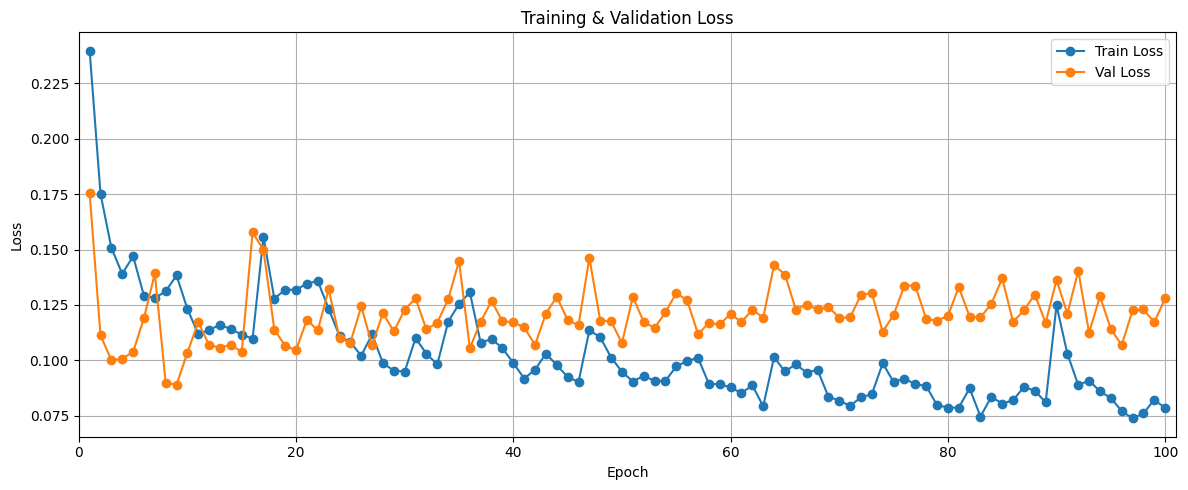

In [18]:
# Cretaing an arry for the number of epochs
epochs = np.arange(1, num_epochs + 1)


fig, axes = plt.subplots(1, 1, figsize=(12, 5))

# Training & Validation Loss plot
axes.plot(epochs, train_losses, label="Train Loss", marker="o")
axes.plot(epochs, val_losses, label="Val Loss", marker="o")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.set_title("Training & Validation Loss")
axes.legend()
axes.grid()
axes.set_xlim(0,101)


plt.tight_layout()
plt.savefig('Loss_plot_housing.png')
plt.show()

In [19]:
# lets get an idea of how off we are in dollars
MSE = avg_train_loss
mse_dollars = MSE * (target_std ** 2)
print(np.sqrt(mse_dollars))

46307.84469816627


0       9.188064
1      10.208960
2       6.354857
3       6.602202
4       6.091534
         ...    
484     9.844355
485    10.704541
486     9.226508
487    10.023343
488    18.530550
Name: MEDV, Length: 489, dtype: float64


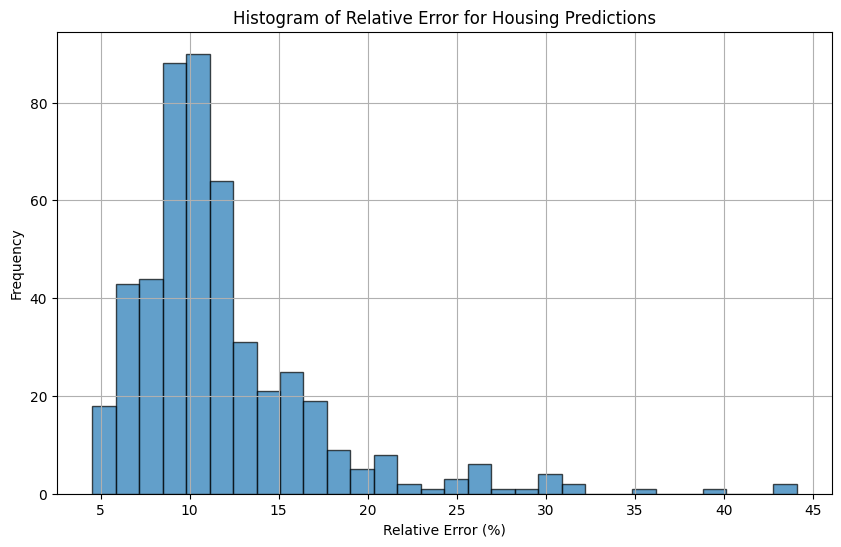

In [20]:
# we can get a rough approximation of the relative error of each sample by dividing mse_dollars by the prices of the original data (before normalizing)


relative_error = (np.sqrt(mse_dollars)/data2['MEDV']) * 100
print(relative_error)

# Plot histogram of relative errors
plt.figure(figsize=(10, 6))
plt.hist(relative_error, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Relative Error (%)")
plt.ylabel("Frequency")
plt.title("Histogram of Relative Error for Housing Predictions")
plt.grid(True)
plt.savefig("histogram_relative_errors.png")
plt.show()

## Test loop

### Now that we trained the model, we can see how it fairs with untrained data and calculate metrics like the mean squared error, mean absolute error, and the Root mean squared error

In [21]:

# Setting the model to evaluation mode
model.eval()


all_preds = []
all_targets = []

# Testing Phase
with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        outputs = model(X_batch)  # Get model predictions
        all_preds.extend(outputs.squeeze().tolist())  # Convert tensor to list
        all_targets.extend(y_batch.tolist())  # Convert true values to list

# Converting lists to NumPy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Computing Evaluation Metrics
mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_targets, all_preds)


print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")



Test MSE: 0.1656
Test RMSE: 0.4070
Test MAE: 0.2181


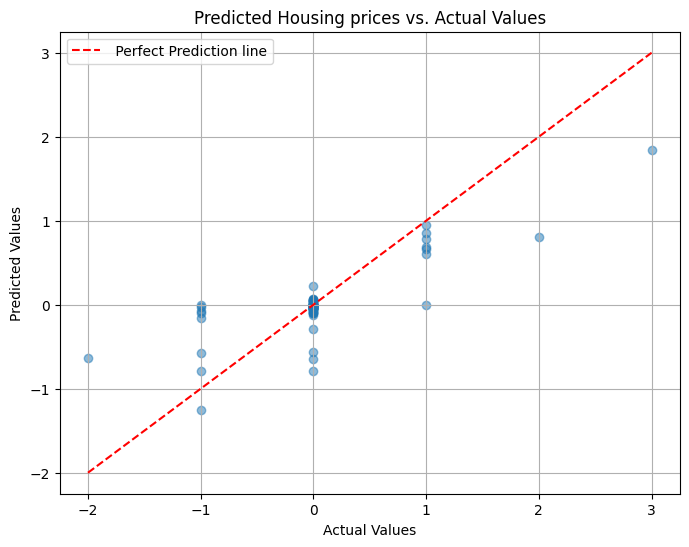

In [22]:
# We can also visualize how good the model is at predicting house prices by having a plot of the predicted vs actual values (from test dataset)

plt.figure(figsize=(8, 6))
plt.scatter(all_targets, all_preds, alpha=0.5)
plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], color='red', linestyle='--', label = ' Perfect Prediction line')  
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted Housing prices vs. Actual Values")
plt.grid()
plt.legend()
plt.savefig('predicted_vs_actual.png')
plt.show()

# Ideally all points would fall on the perfect prediction line, but as we can see there is some deviation especially around the mean